# Model from dataset_2 150 epochs

In [2]:
pip install pandas matplotlib ultralytics ipython

Note: you may need to restart the kernel to use updated packages.


## Training Curve

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# ================= ⚙️ ตั้งค่า (แก้ตรงนี้) =================
# ระบุ Path ของไฟล์ CSV
CSV_PATH = "runs/chess_board_finetuned_v2/exp_round_3_low_lr/results.csv"

# ปรับระดับความสมูท (0.0 = ไม่สมูทเลย, 0.9 = สมูทมาก)
SMOOTH_FACTOR = 0.6  

# ระบุ Path สำหรับบันทึกรูปกราฟ
OUTPUT_PATH = "runs/chess_board_finetuned_v2/exp_round_3_low_lr/Training_Graph_Report.png" # แก้เป็นชื่อที่คุณต้องการ
# ========================================================

def plot_training_results_smooth_with_points(csv_file):
    if not os.path.exists(csv_file):
        print(f"❌ ไม่เจอไฟล์: {csv_file}")
        return

    # อ่านไฟล์ และลบช่องว่างหัวตาราง
    data = pd.read_csv(csv_file)
    data.columns = [c.strip() for c in data.columns]

    epochs = data['epoch']

    # สร้างหน้ากระดาษ
    fig, ax = plt.subplots(2, 5, figsize=(20, 8))
    ax = ax.ravel()

    # รายชื่อกราฟ
    plots = [
        ('train/box_loss', 'Train Box Loss'), ('train/cls_loss', 'Train Class Loss'), ('train/dfl_loss', 'Train DFL Loss'),
        ('metrics/precision(B)', 'Precision'), ('metrics/recall(B)', 'Recall'),
        ('val/box_loss', 'Val Box Loss'), ('val/cls_loss', 'Val Class Loss'), ('val/dfl_loss', 'Val DFL Loss'),
        ('metrics/mAP50(B)', 'mAP @ 50'), ('metrics/mAP50-95(B)', 'mAP @ 50-95')
    ]

    for i, (col, title) in enumerate(plots):
        if col in data.columns:
            raw_data = data[col]
            
            # --- 1. วาดเส้นข้อมูลดิบ (Raw) มีจุด ---
            ax[i].plot(epochs, raw_data, 
                       label='Results', 
                       linewidth=1, 
                       color='tab:blue',  # บังคับสีฟ้า
                       marker='o',        # ✅ ใส่จุดวงกลม
                       markersize=3)      # ✅ ขนาดจุด (ปรับเลขนี้ถ้าอยากได้ใหญ่ขึ้น)

            # --- 2. คำนวณและวาดเส้นสมูท (Smooth) ---
            smooth_data = raw_data.ewm(alpha=(1 - SMOOTH_FACTOR)).mean()
            
            # วาดเส้นประสีส้ม
            ax[i].plot(epochs, smooth_data, 
                       color='orange', 
                       linestyle='--', 
                       linewidth=2,       # เพิ่มความหนานิดนึงให้เด่น
                       label='Smooth')

            # ตกแต่งกราฟ
            ax[i].set_title(title, fontweight='bold', fontsize=11)
            ax[i].grid(True, alpha=0.3)
            ax[i].legend(loc='best', fontsize=8)
            
            if 'loss' in col:
                ax[i].set_yscale('log')
        else:
            ax[i].text(0.5, 0.5, 'Not Found', ha='center')

    plt.suptitle(f'Training Results (With Points): {os.path.basename(os.path.dirname(csv_file))}', fontsize=16)
    plt.tight_layout()
    
    # Save รูป
    save_path = OUTPUT_PATH
    plt.savefig(save_path, dpi=300)
    print(f"✅ กราฟสวยๆ บันทึกแล้วที่: {save_path}")
    plt.show()

# รันฟังก์ชัน
plot_training_results_smooth_with_points(CSV_PATH)

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x80 in position 64: invalid start byte

## Confusion Matrix

🚀 กำลังโหลดโมเดล: runs/chess_board_finetuned_v2/exp_round_3_low_lr/weights/best.pt
Ultralytics 8.3.235 🚀 Python-3.13.8 torch-2.9.1 CPU (Apple M4)
Model summary (fused): 72 layers, 11,130,228 parameters, 0 gradients, 28.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1988.2±347.3 MB/s, size: 12487.3 KB)
val: Scanning /Users/098f/Desktop/DigImg/dataset_2_restruct_AJ/labels/val.cache... 37 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 37/37 23.5Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 5.2s/it 15.7s<13.9s
                   all         37        843      0.951      0.933      0.971       0.84
          black-bishop         32         55      0.971      0.927      0.971      0.836
            black-king         36         36      0.799      0.992      0.901      0.777
          black-knight         37         58       0.93       0.92      0.948      0.802
            black-pawn         28     

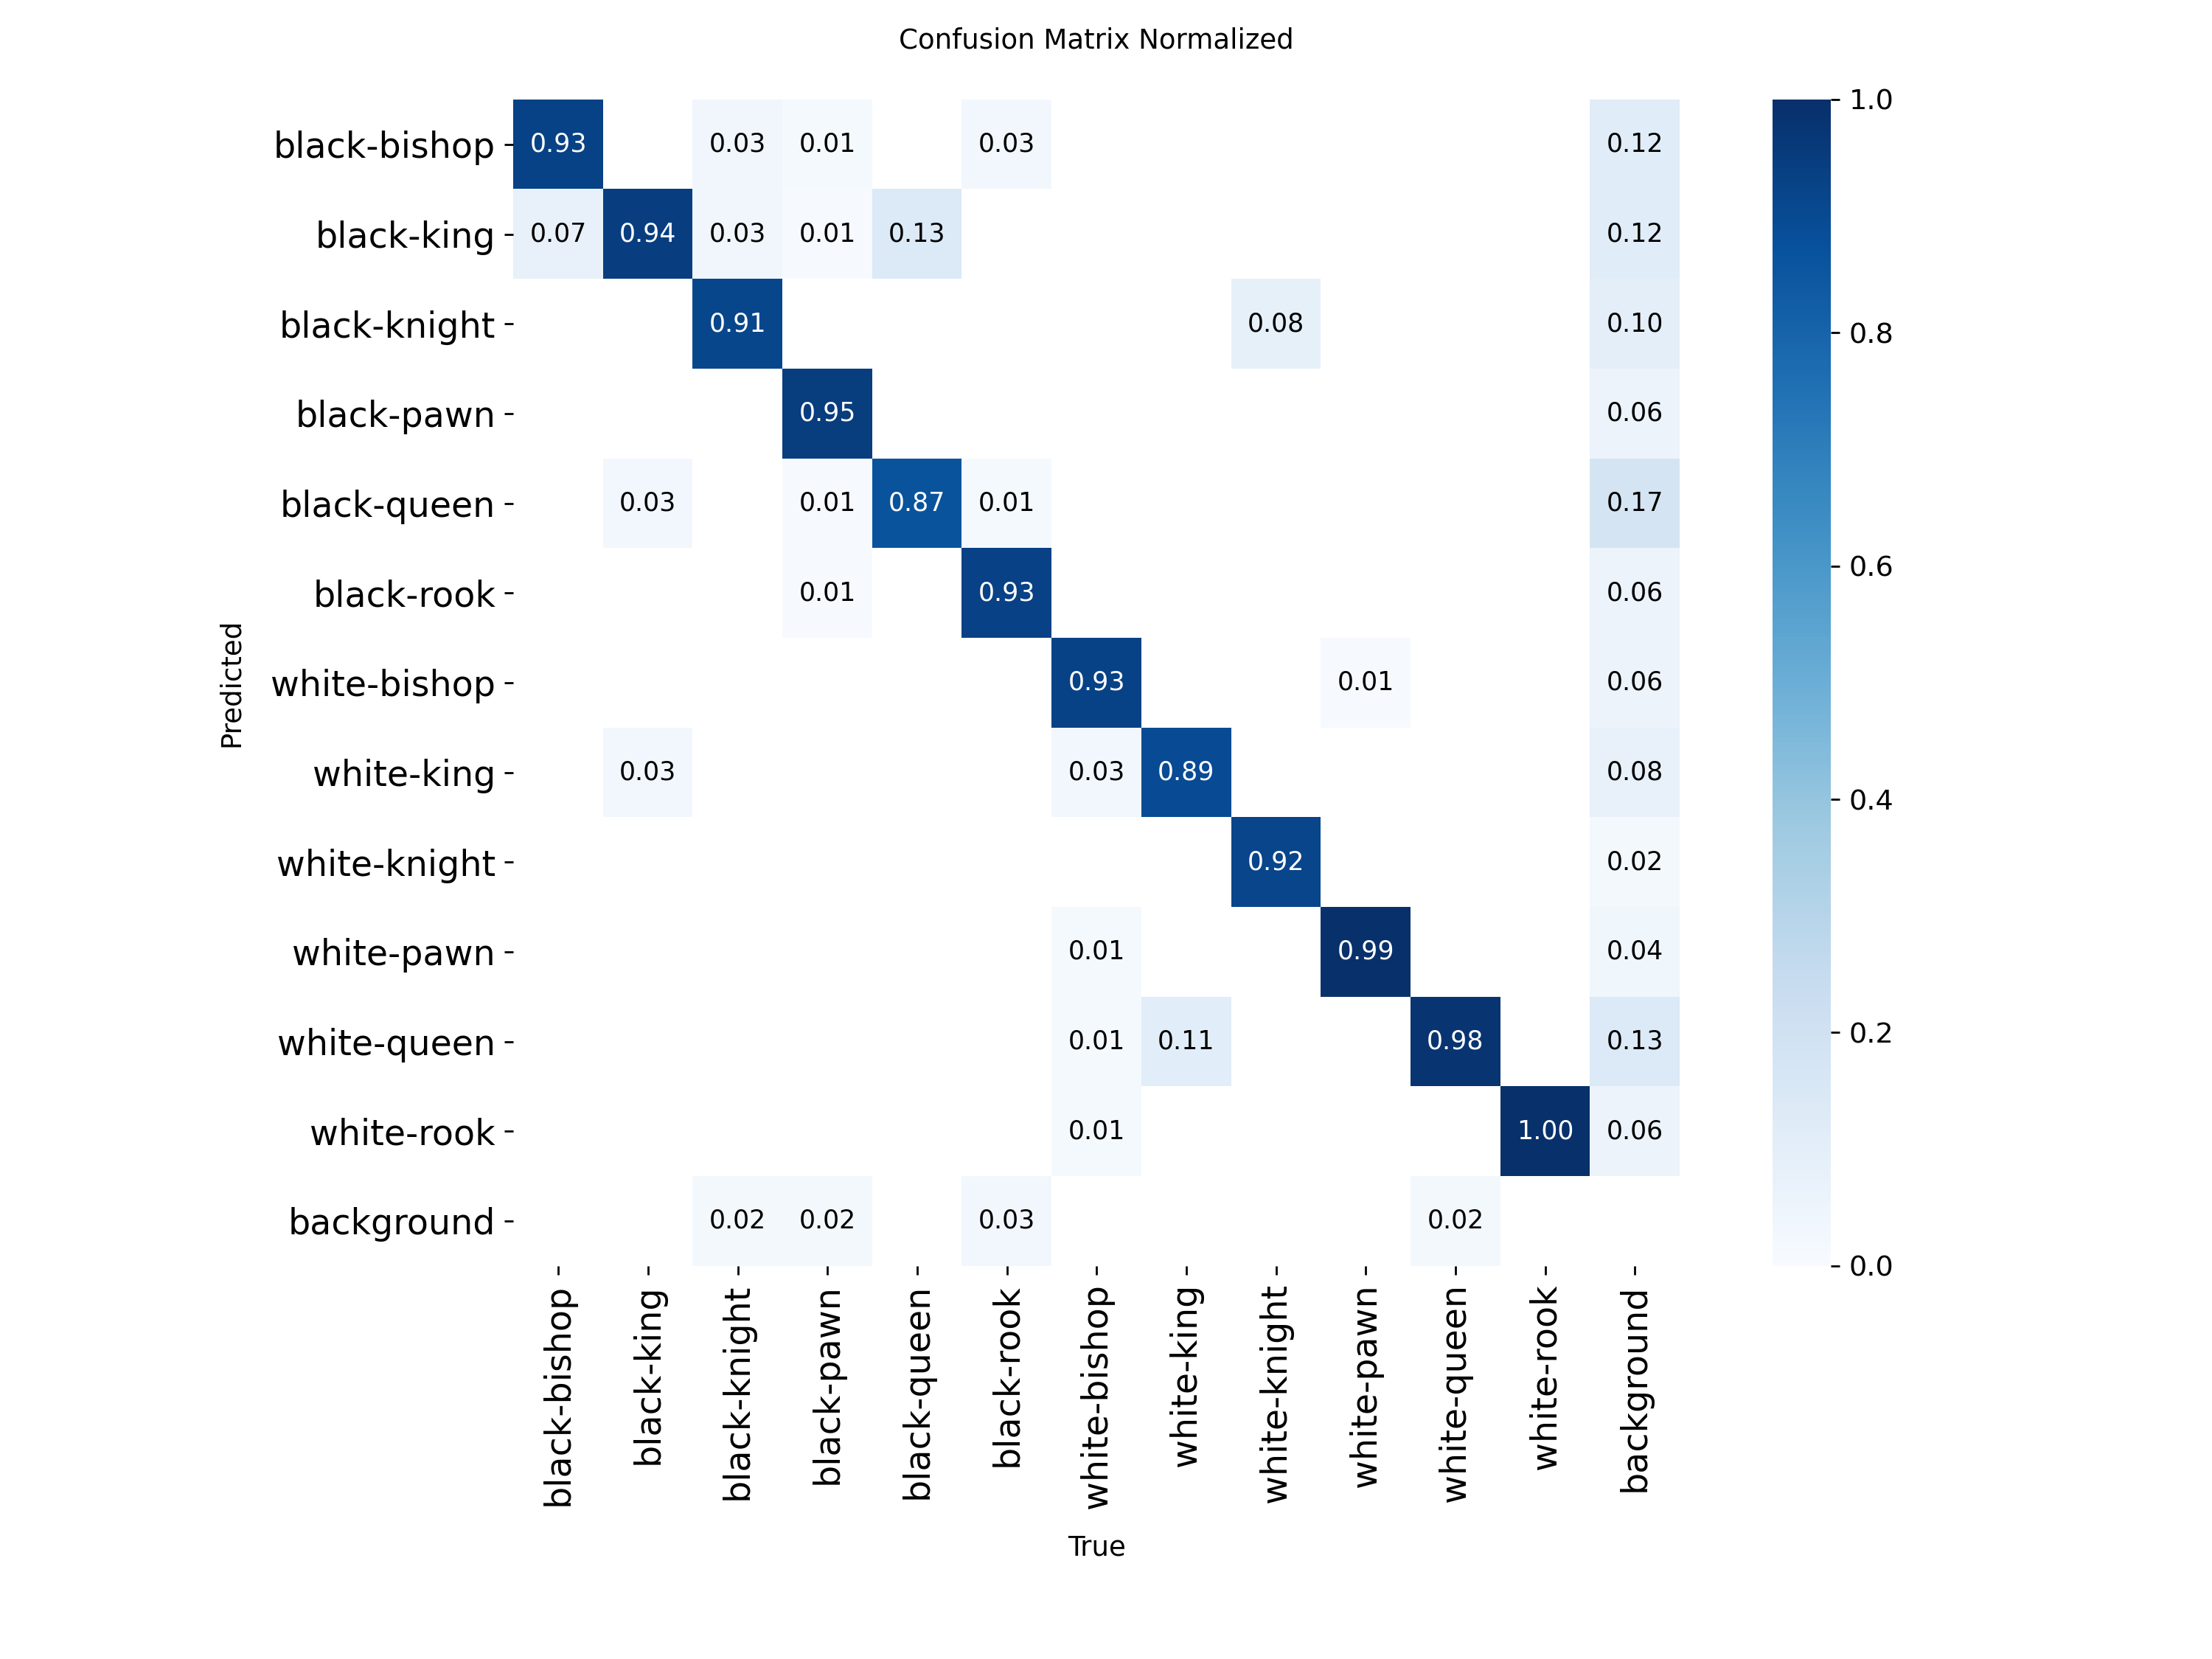

In [5]:
# --- CELL 2: สร้าง Confusion Matrix จากการ Val Model (แก้ไข Path) ---
from ultralytics import YOLO
import os
from IPython.display import Image, display

# 1. Path Model
MODEL_PATH = "runs/chess_board_finetuned_v2/exp_round_3_low_lr/weights/best.pt"

# 2. Path Data (อันเดิม)
DATA_YAML = "dataset_2_restruct_AJ/data.yaml" 

# กำหนดโฟลเดอร์ที่จะเก็บผลลัพธ์ให้ชัดเจน (ใช้ตัวแปรเดียว จะได้ไม่หลง)
OUTPUT_PROJECT = "runs/chess_board_finetuned_v2"
OUTPUT_NAME = "confusion_matrix_gen"

if os.path.exists(MODEL_PATH) and os.path.exists(DATA_YAML):
    print(f"🚀 กำลังโหลดโมเดล: {MODEL_PATH}")
    model = YOLO(MODEL_PATH)
    
    # สั่ง Val
    model.val(
        data=DATA_YAML,
        split='val',
        project=OUTPUT_PROJECT,  # <--- เซฟที่นี่
        name=OUTPUT_NAME,        # <--- โฟลเดอร์ย่อยชื่อนี้
        plots=True
    )
    
    # สร้าง Path รูปภาพให้ตรงกับที่เซฟไปตะกี้
    # Path จริงจะเป็น: runs/chess_board_finetuned_v2/confusion_matrix_gen/confusion_matrix_normalized.png
    cm_path = f"{OUTPUT_PROJECT}/{OUTPUT_NAME}/confusion_matrix_normalized.png"
    
    if os.path.exists(cm_path):
        print("\n📸 Confusion Matrix:")
        display(Image(filename=cm_path, width=800))
    else:
        print(f"⚠️ หาไฟล์ไม่เจอที่: {cm_path}")
        print("ลองเช็คใน Folder runs/chess_board_finetuned_v2 ด้วยตาเปล่าดูครับว่ามีไฟล์ไหม")
else:
    print(f"❌ ไม่เจอไฟล์ Model หรือ data.yaml")

In [1]:
!pip install ultralytics

In [7]:
from ultralytics import YOLO

# 1. โหลดโมเดลที่ train เสร็จแล้ว
model = YOLO('runs/chess_finetune_v2_fix_bg/exp_negative_samples/weights/best.pt')

# 2. Rerun Validation โดยระบุไฟล์ data.yaml
# (YOLOv8 จะใช้ path ของ validation set ที่ระบุใน data.yaml)
metrics = model.val(data='dataset_2_restruct_AJ/data.yaml')

# 3. แสดงผลลัพธ์ทั้งหมด
print("\n📊 Validation Results:")
print("=" * 40)
print(f"  mAP50:     {metrics.box.map50:.4f}")
print(f"  mAP50-95:  {metrics.box.map:.4f}")
print(f"  Precision: {metrics.box.mp:.4f}") # <--- ค่า Mean Precision
print(f"  Recall:    {metrics.box.mr:.4f}") # <--- ค่า Mean Recall
print("=" * 40)

Ultralytics 8.3.235 🚀 Python-3.13.8 torch-2.9.1 CPU (Apple M4)
Model summary (fused): 72 layers, 11,130,228 parameters, 0 gradients, 28.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2959.1±80.6 MB/s, size: 12351.1 KB)
val: Scanning /Users/098f/Desktop/DigImg/dataset_2_restruct_AJ/labels/val.cache... 37 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 37/37 149.8Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 7.4s/it 22.1s<20.1s
                   all         37        843      0.937      0.941      0.966      0.842
          black-bishop         32         55      0.957      0.927      0.976       0.86
            black-king         36         36       0.76          1      0.866      0.751
          black-knight         37         58      0.906      0.826      0.919      0.779
            black-pawn         28        149      0.994       0.96      0.983      0.851
           black-queen         3